![MLTrain logo](https://mltrain.cc/wp-content/uploads/2017/11/mltrain_logo-4.png "MLTrain logo")

----------------
# Preparations #
The readonly public link to the Databricks notebook is [here](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2554702015877214/632957142081533/8550007600826264/latest.html)  

High-level Spark APIs (DataFrame, Dataset and SparkSql) are made available through a SparkSession cluster-level object.  
In the following we'll use a SparkSession to construct Spark DataFrames, register them as tables and execute SparkSQL over these tables.  
  
__Databricks Community__ notebooks come with a precooked SparkSession object instantiated as `spark`  
If you're running this notebook localy add a cell with the following code before proceeding with the rest of the cells:

In [9]:
%run changeNBLayout.py

from pyspark.sql import SparkSession as spark
dataPath = ''

Otherwise add a cell with the following code:  

### Check the Databricks environment for basic functionality ###

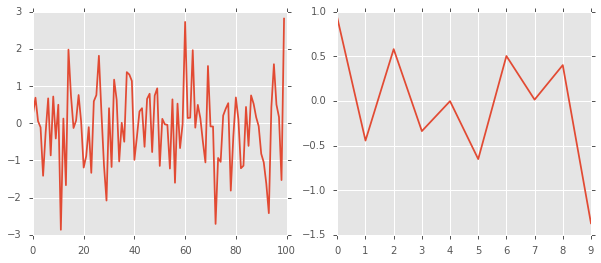

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as skl
import datetime as dt

from os import linesep as endl

with plt.style.context(['seaborn-notebook', 'ggplot']):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize = [10, 4])
    ax1.plot(np.random.randn(100))

    df = pd.DataFrame(np.random.randn(10, 4), columns = ['one', 'two', 'three', 'four'])
    ax2.plot(df.two)

display(fig)


In [18]:
sses = spark.builder.appName("ssapp01").getOrCreate()

### Upload a csv file to your Databricks cluster ###  
In Databricks we have to upload the .csv file manually:  
1. From the left of this screen select 'Data' > Table +,  
2. drag and drop to the rectangle on the right the file appleSales.csv that's contained in PfBDAaML Github repository  
  
The file is stored on your cluster under `/FileStore/tables`  
We use SparkSession's csv reader to create a Spark Dataframe object from the csv file:

In [19]:
import os
df = sses.read.csv(os.path.join(dataPath, 'appleStocks.csv'), header = True)
print type(df)
df.show(n = 100)


<class 'pyspark.sql.dataframe.DataFrame'>
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
|2010-01-11|21

__NB:__ There's no type info in the csv file so everything is parsed as string.  
This is not good for doing transformations on the file's data.  
We ameliorate this by setting up a _schema_ for the file explicitly later on.

In [20]:
print 'df fields and their types:'
df.printSchema()

df fields and their types:
root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Adj Close: string (nullable = true)



In [30]:
from pyspark.sql.types import StructField, StringType, IntegerType, DateType, FloatType, StructType

dataSchema = [
    StructField("Date", DateType(), nullable = True), 
    StructField("Open", FloatType(), True),
    StructField("Close", FloatType(), True),
    StructField("High", FloatType(), True),
    StructField("Low", FloatType(), True),
    StructField("Volume", IntegerType(), True),
    StructField("Adj Close", StringType(), True)]

dataSchema = StructType(fields = dataSchema)
df = sses.read.csv(os.path.join(dataPath, 'appleStocks.csv'), schema = dataSchema)

df.printSchema()
df.show(n = 10, truncate = True)

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: string (nullable = true)

+----------+---------+---------+---------+---------+---------+------------------+
|      Date|     Open|    Close|     High|      Low|   Volume|         Adj Close|
+----------+---------+---------+---------+---------+---------+------------------+
|      null|     null|     null|     null|     null|     null|              null|
|2010-01-04|   213.43|    214.5|   212.38|   214.01|123432400|         27.727039|
|2010-01-05|214.59999|   215.59|   213.25|214.37999|150476200|27.774976000000002|
|2010-01-06|214.37999|   215.23|   210.75|   210.97|138040000|27.333178000000004|
|2010-01-07|   211.75|    212.0|   209.05|   210.58|119282800|          27.28265|
|2010-01-08|210.29999|    212.0|   209.06|211.98001|111902700|         27.464034|
|2

# Projections and selections #

Slicing rows and columns of pyspark DataFrames is similar to pandas:

In [31]:
df[['Date', 'Open']].show(5)

# Selection in pySpark is a relational algebra projection:
df.select(['Open', 'Close']).show(5)

+----------+---------+
|      Date|     Open|
+----------+---------+
|      null|     null|
|2010-01-04|   213.43|
|2010-01-05|214.59999|
|2010-01-06|214.37999|
|2010-01-07|   211.75|
+----------+---------+
only showing top 5 rows

+---------+------+
|     Open| Close|
+---------+------+
|     null|  null|
|   213.43| 214.5|
|214.59999|215.59|
|214.37999|215.23|
|   211.75| 212.0|
+---------+------+
only showing top 5 rows



Select the rows of the DataFrame with Date in the specified datetime range.  
date_range is a pandas ctor for date ranges, similar to np.arange for ints

In [22]:
df[df['Date'].isin(*pd.date_range(dt.datetime(2016, 1, 1), dt.datetime(2016, 2, 1)))].show(5)

+----+----+----+---+-----+------+---------+
|Date|Open|High|Low|Close|Volume|Adj Close|
+----+----+----+---+-----+------+---------+
+----+----+----+---+-----+------+---------+



Select the volumes of stocks exchanged after 01 Jan 2016

In [23]:
df.filter(df['Date'] > dt.datetime(2016, 1, 1)).select(['Volume']).show(5)

+--------+
|  Volume|
+--------+
|67649400|
|55791000|
|68457400|
|81094400|
|70798000|
+--------+
only showing top 5 rows



# Adding new columns #

In [24]:
import pyspark.sql.functions as pf
df = df.withColumn('TamperedHigh', df.High * 1.05)
df.show(5)

+----------+----------+----------+------------------+------------------+---------+------------------+------------------+
|      Date|      Open|      High|               Low|             Close|   Volume|         Adj Close|      TamperedHigh|
+----------+----------+----------+------------------+------------------+---------+------------------+------------------+
|2010-01-04|213.429998|214.499996|212.38000099999996|        214.009998|123432400|         27.727039|225.22499580000002|
|2010-01-05|214.599998|215.589994|        213.249994|        214.379993|150476200|27.774976000000002|       226.3694937|
|2010-01-06|214.379993|    215.23|        210.750004|        210.969995|138040000|27.333178000000004|          225.9915|
|2010-01-07|    211.75|212.000006|        209.050005|            210.58|119282800|          27.28265|222.60000630000002|
|2010-01-08|210.299994|212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|222.60000630000002|
+----------+----------+---------

## Functions
There is a variety of functions you can import from pyspark.sql.functions.  
Check out the [Spark documentation](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) for the full list available

Here we import `month` ufunc from `pyspark.sql.functions` (a great deal of ufuncs are defined there).  
Then create a binned column 'Month' to use it for our aggregations in the sequel

In [36]:
df = df.withColumn('Month', pf.month(df.Date))
df.select('Date', 'Month').sample(False, 0.1).show(5)

+----------+-----+
|      Date|Month|
+----------+-----+
|2010-01-27|    1|
|2010-02-17|    2|
|2010-03-02|    3|
|2010-03-15|    3|
|2010-03-17|    3|
+----------+-----+
only showing top 5 rows



----------------------------------------------
# Grouping and aggregating #

As in Pandas, the groupby method returns a `groupby` object which we can aggregate on:

In [37]:
applesGroup = df.groupby('Month')

In [38]:
applesGroup.max('Open').show(2)

+-----+------------------+
|Month|         avg(Open)|
+-----+------------------+
|   12|302.76953155722396|
| null|              null|
+-----+------------------+
only showing top 2 rows



In [55]:
applesGroup.max('Open').show(2)

+-----+---------+
|Month|max(Open)|
+-----+---------+
|   12|   593.65|
| null|     null|
+-----+---------+
only showing top 2 rows



In [56]:
applesGroup.count().show(2)

+-----+-----+
|Month|count|
+-----+-----+
|   12|  149|
| null|    1|
+-----+-----+
only showing top 2 rows



### Simultaneous aggregations ###

In [14]:
applesGroup.agg({'High': 'min', 'Low': 'max', 'Open': 'avg'}).show(5)

NameError: name 'applesGroup' is not defined

# OrderBy method #

In [58]:
df.orderBy("Month").show(5)

+----------+---------+------+------+---------+---------+------------------+-----+------------------+
|      Date|     Open| Close|  High|      Low|   Volume|         Adj Close|Month|      TamperedHigh|
+----------+---------+------+------+---------+---------+------------------+-----+------------------+
|      null|     null|  null|  null|     null|     null|              null| null|              null|
|2010-01-04|   213.43| 214.5|212.38|   214.01|123432400|         27.727039|    1|222.99900512695314|
|2010-01-06|214.37999|215.23|210.75|   210.97|138040000|27.333178000000004|    1|221.28750000000002|
|2010-01-05|214.59999|215.59|213.25|214.37999|150476200|27.774976000000002|    1|223.91250000000002|
|2010-01-07|   211.75| 212.0|209.05|   210.58|119282800|          27.28265|    1|219.50250320434571|
+----------+---------+------+------+---------+---------+------------------+-----+------------------+
only showing top 5 rows



Here we use pySpark's `year` function to get the year of the Date field and order the DataFrame's rows by year

In [59]:
df.orderBy(pf.year(df.Date).desc()).show(5)

+----------+------+------+------+------+--------+------------------+-----+------------------+
|      Date|  Open| Close|  High|   Low|  Volume|         Adj Close|Month|      TamperedHigh|
+----------+------+------+------+------+--------+------------------+-----+------------------+
|2016-01-04|102.61|105.37| 102.0|105.35|67649400|        102.612183|    1|107.10000000000001|
|2016-01-11| 98.97| 99.06| 97.34| 98.53|49739400|          95.96942|    1|102.20699615478516|
|2016-01-05|105.75|105.85|102.41|102.71|55791000|100.04079200000001|    1|107.53050384521485|
|2016-01-06|100.56|102.37| 99.87| 100.7|68457400|         98.083025|    1|104.86350288391114|
|2016-01-07| 98.68|100.13| 96.43| 96.45|81094400|         93.943473|    1|101.25150032043457|
+----------+------+------+------+------+--------+------------------+-----+------------------+
only showing top 5 rows



And here we calculate aggregates over all our data using the function below.  
  
__Notice however__ that in order to display the result we were forced to _wrap_ our aggregate to a pyspark DataFrame `select` method.  
This is because the aggregate is a column pySpark object and column objects do not have a show or collect function.  
  
More precisely, column objects are expressions; they __do not__ contain data but are related (Attached) to the dataframe objects they come from.  

In [81]:
from pyspark.sql.functions import countDistinct, avg, stddev, year
df.select(countDistinct(year(df.Date))).show(5)

+--------------------------+
|count(DISTINCT year(Date))|
+--------------------------+
|                         7|
+--------------------------+



In [82]:
df.select(avg('Open')).show()
df.select(stddev('Low')).show()

+------------------+
|         avg(Open)|
+------------------+
|313.07631053340015|
+------------------+

+------------------+
|  stddev_samp(Low)|
+------------------+
|185.14710364848838|
+------------------+



-----------------------
# Exporting to pandas #

Date     datetime64[ns]
High            float64
Low             float64
Open            float64
Close           float64
dtype: object


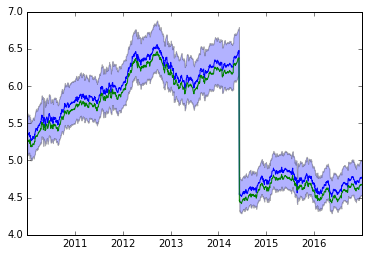

In [84]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.width', 144)

pandf = df.select('Date', 'High', 'Low', 'Open', 'Close').toPandas()
pandf['Date'] = pd.to_datetime(pandf['Date'], errors = 'raise')
pandf = pandf.sort_values(axis = 'index', by = 'Date')

for col in pandf.columns[1:]:
    pandf[col] = pandf[col].astype(float)

# Normalize
pandf.High = pandf.High.map(lambda _: np.log(_ + 1.) * 1.05)
pandf.Low = pandf.Low.map(lambda _: np.log(_ + 1.) * .95)
pandf[['Open', 'Close']] = pandf[['Open', 'Close']].apply(lambda _: np.log(_ + 1.))

print pandf.dtypes
# print np.sort(pandf.Open.unique())[:10]

pandfs = pandf['Open'].sample(100, random_state = 101)

fig = plt.figure()
ax = fig.add_subplot('111')
ax.fill_between(x = pandf.Date.values, y1 = pandf.High.values, y2 = pandf.Low.values, alpha = .3)
ax.plot(pandf.Date.values, pandf.Open.values, pandf.Date.values, pandf.Close.values - .1)
display(fig)

### Using SQL

To use SQL queries directly with the dataframe, you will need to register it to a temporary view:

In [85]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("appleStocksView")

In [87]:
sql_results = sses.sql("SELECT * FROM appleStocksView")

In [88]:
sql_results

DataFrame[Date: date, Open: float, Close: float, High: float, Low: float, Volume: int, Adj Close: string, Month: int, TamperedHigh: double]

Notice that __nothing__ has happened yet.  
Again, this is because everythin still 'lives' in spark.  
We have to call show to 'export' the results to the console.  
We would have used `collect` to export the results to a list of records (Spark 'row' objects)

In [90]:
sql_results.show(5)

+----------+---------+------+------+---------+---------+------------------+-----+------------------+
|      Date|     Open| Close|  High|      Low|   Volume|         Adj Close|Month|      TamperedHigh|
+----------+---------+------+------+---------+---------+------------------+-----+------------------+
|      null|     null|  null|  null|     null|     null|              null| null|              null|
|2010-01-04|   213.43| 214.5|212.38|   214.01|123432400|         27.727039|    1|222.99900512695314|
|2010-01-05|214.59999|215.59|213.25|214.37999|150476200|27.774976000000002|    1|223.91250000000002|
|2010-01-06|214.37999|215.23|210.75|   210.97|138040000|27.333178000000004|    1|221.28750000000002|
|2010-01-07|   211.75| 212.0|209.05|   210.58|119282800|          27.28265|    1|219.50250320434571|
+----------+---------+------+------+---------+---------+------------------+-----+------------------+
only showing top 5 rows



In [101]:
sses.sql("SELECT avg(High), avg(Low), avg(Open) FROM appleStocksView WHERE Date > '2016-10-01' group by Month").show(5)

+------------------+------------------+------------------+
|         avg(High)|          avg(Low)|         avg(Open)|
+------------------+------------------+------------------+
| 113.5452379499163|114.33571443103608|113.99571373349144|
|114.94142768496559|115.70714314778645|115.74380856468564|
| 108.9885722569057|110.15428524925595|110.08238038562592|
+------------------+------------------+------------------+

